# 1. 狮子、老虎和熊

我们参观野生动物园保护区，看到了3只狮子、2只老虎和1头熊，如果我们观察到任何动物的机会均等，那么动物园所有动物中，狮子、老虎和熊的占比各是多少？  
先验分布可以假定每种动物的占比是一样的，但各类动物占比不是独立的，所有的占比之和为1。可以用狄利克雷分布来建模。

## 2. 狄利克雷分布

**狄利克雷分布**$Dir(\alpha)$ , 是一组$k$个连续多元随机分布的分布族，这组多元连续分布随机变量的参数为$\mathbf{a}=(\alpha_{1}, \alpha_{2}, \cdots, \alpha_{k})$，$\alpha_{i}\geq0$。它是贝塔（$\mathrm {B} $）分布在多元维度上的推广，也被称为多元贝塔布(MBD)。在贝叶斯理论中，狄利克雷分布是分类分布和多项式分布的共轭先验分布，因此常被用作先验分布。狄利克雷分布的密度函数为：

$$f\left( {{x}_{1}},\cdots ,{{x}_{k}};{{\alpha }_{1}},\cdots ,{{\alpha }_{k}} \right)=\dfrac{1}{\mathrm {B}\left( \alpha  \right)}\prod\limits_{i=1}^{K}{x_{i}^{{{\alpha }_{i}}-1}}$$

且对于所有$i\in [1,K]$，满足以下条件：

$$\left\{ \begin{matrix}
   \sum\limits_{i=1}^{k}{{{x}_{i}}=1}  \\
   {{x}_{i}}\ge 0  \\
   {{\alpha }_{i}}\ge 0  \\
\end{matrix} \right.
$$

其中归一化常数$\mathrm {B}$为：

$${\displaystyle \mathrm {B} ({\boldsymbol {\alpha }})={\frac {\prod _{i=1}^{K}\Gamma (\alpha _{i})}{\Gamma \left(\sum _{i=1}^{K}\alpha _{i}\right)}},\qquad {\boldsymbol {\alpha }}=(\alpha _{1},\ldots ,\alpha _{K})}$$

狄利克雷分布的**边缘分布**是贝塔分布：
$${\displaystyle X_{i}\sim \operatorname {Beta} (\alpha _{i},\alpha _{0}-\alpha _{i})}$$其中，$$\displaystyle{\alpha_0 = \sum_1^k \alpha_i}$$

# 3. 类Dirichlet

In [1]:
from tools import Beta, MakePmfFromItems, MakePmfFromDict
import numpy

class Dirichlet(object):
    """狄利克雷分布模型。
    """
    
    def __init__(self, n, conc=1, name=''):
        """初始化狄利克雷分布
        n: 维度
        conc: 集中度参数 (数值越小，集中度越高)
        name: 实例的名称
        """
        if n < 2:
            raise ValueError('狄利克雷分布的维数应当大于或等于2')

        self.n = n
        self.params = numpy.ones(n, dtype=numpy.float) * conc
        self.name = name

    def Update(self, data):
        """更新分布。
        data: 观测值构成的列表，与对应参数顺序保持一致。"""
        m = len(data)
        self.params[:m] += data

    def Random(self):
        """从分布生成随机变量。gamma抽样。

        Returns:归一化向量（列表）
        """
        p = numpy.random.gamma(self.params)
        return p / p.sum()

    def Likelihood(self, data):
        """似然函数。
        从分布组合中选择一个随机的概率向量。
        
        Returns: 概率值
        """
        m = len(data)
        if self.n < m:
            return 0

        x = data
        p = self.Random()
        q = p[:m] ** x
        return q.prod()

    def LogLikelihood(self, data):
        """对数似然分布.

        Returns: 对数概率值。
        """
        m = len(data)
        if self.n < m:
            return float('-inf')

        x = self.Random()
        y = numpy.log(x[:m]) * data
        return y.sum()

    def MarginalBeta(self, i):
        """计算第i个元分布的边际分布（Beta分布）.

        i: int
        Returns: Beta分布
        """
        alpha0 = self.params.sum()
        alpha = self.params[i]
        # Beta是在tools中定义的一个类
        return Beta(alpha, alpha0 - alpha)

    def PredictivePmf(self, xs, name=''):
        """Makes a predictive distribution.

        xs: values to go into the Pmf

        Returns: Pmf that maps from x to the mean prevalence of x
        """
        alpha0 = self.params.sum()
        ps = self.params / alpha0
        return MakePmfFromItems(zip(xs, ps), name=name)

 Dirichlet类的__init__()方法的初始化功能很简单，只需要指定维度并给出集中度参数即可。狄利克雷分布的边缘分布是Beta分布， Dirichlet类的MarginalBeta（）方法可用于计算随机变量的边缘分布。

# 4. 种群密度的后验分布

In [2]:
dirichlet = Dirichlet(3)
names = ['狮子','老虎','熊']
for i in range(3):
    beta = dirichlet.MarginalBeta(i)
    print(F"{names[i]}的占比的先验分布均值为:{beta.Mean():.02}。")


狮子的占比的先验分布均值为:0.33。
老虎的占比的先验分布均值为:0.33。
熊的占比的先验分布均值为:0.33。


狄利克雷分布是分类分布和多项式分布的共轭先验分布，因此在Update方法中只需将参数简单相加即可。结果如下：

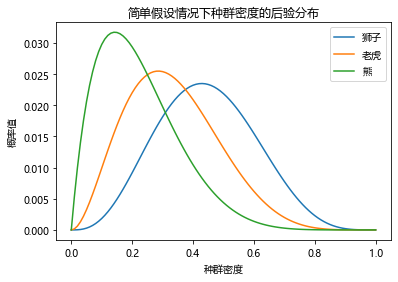

In [3]:
data = [3,2,1]
dirichlet.Update(data)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
for i in range(3):
    beta = dirichlet.MarginalBeta(i)
    beta_pmf = beta.MakePmf()
    
    x,y = zip(*beta_pmf.Items())
    plt.plot(x,y,label=names[i])   

plt.title("简单假设情况下种群密度的后验分布")
plt.xlabel('种群密度')
plt.ylabel('概率值')
plt.legend()
plt.show()

本文例子来自Allen B. Downey的《Think Bayes》一书，内容作了增补和修改。有关贝叶斯统计模型的更多例子及完整源代码请访问[GitHub](https://github.com/HuRongxing/thinkbayes)。